In [28]:
# %% Cell 1: Đọc và xử lý dữ liệu cơ bản

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TRAIN_FILE = "D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/train_70_15_15.csv"
VAL_FILE   = "D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/val_70_15_15.csv"
TEST_FILE  = "D:/TunTun/HTTT2022.2/IS403.P23-Gold/Dataset/Splits/test_70_15_15.csv"

train_df = pd.read_csv(TRAIN_FILE, parse_dates=["Date"])
val_df = pd.read_csv(VAL_FILE, parse_dates=["Date"])
test_df = pd.read_csv(TEST_FILE, parse_dates=["Date"])

def parse_value(x):
    if isinstance(x, str):
        s = x.replace('$','').replace(',','')
        if s.endswith('%'): return float(s[:-1])
        if s.endswith('K'): return float(s[:-1]) * 1e3
        if s.endswith('M'): return float(s[:-1]) * 1e6
        return float(s)
    return x

def clean_df(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].apply(parse_value)
    return df

train_df = clean_df(train_df)
val_df = clean_df(val_df)
test_df = clean_df(test_df)


In [29]:
# %% Cell 2: Ghép dữ liệu, xử lý NaN, chuẩn hóa

df_all = pd.concat([train_df, val_df, test_df]).sort_values("Date").reset_index(drop=True)

# Thay NaN ở cột Vol. bằng giá trị trung bình
vol_mean = df_all['Vol.'].mean()
df_all['Vol.'].fillna(vol_mean, inplace=True)

print("Số lượng NaN từng cột sau xử lý:")
print(df_all.isna().sum())

# Nếu còn NaN khác thì drop
df_all.dropna(inplace=True)

feature_cols = ["Price", "Open", "High", "Low", "Vol.", "Change %", "CPIAUCSL"]

scaler = StandardScaler()
df_all[feature_cols] = scaler.fit_transform(df_all[feature_cols])


Số lượng NaN từng cột sau xử lý:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
CPIAUCSL    0
dtype: int64


C:\Users\Admin\AppData\Local\Temp\ipykernel_12440\2350949884.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Vol.'].fillna(vol_mean, inplace=True)


In [30]:
# %% Cell 3: Tạo dữ liệu dạng chuỗi cho mô hình

SEQ_LEN = 90

def create_multivariate_lagged(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, :])
        y.append(data[i, 0])  # target là Price
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(df_all[feature_cols].values, SEQ_LEN)

n_train = len(train_df) - SEQ_LEN
n_val = len(val_df)

X_train = X_all[:n_train]
X_val = X_all[n_train:n_train+n_val]
X_test = X_all[n_train+n_val:]

y_train = y_all[:n_train]
y_val = y_all[n_train:n_train+n_val]
y_test = y_all[n_train+n_val:]


In [31]:
# %% Cell 4: Tạo DataLoader PyTorch

import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
), batch_size=32, shuffle=False)

val_loader = DataLoader(TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
), batch_size=32)

test_loader = DataLoader(TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
), batch_size=32)


In [32]:
# %% Cell 5: Định nghĩa mô hình WaveNet

import torch.nn as nn

class WaveNetBlock(nn.Module):
    def __init__(self, dilation, in_ch, out_ch, kernel_size=2):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, dilation=dilation, padding='same')
        self.relu = nn.ReLU()
        self.skip = nn.Conv1d(out_ch, in_ch, kernel_size=1)

    def forward(self, x):
        out = self.relu(self.conv(x))
        skip = self.skip(out)
        if skip.size(2) != x.size(2):
            min_len = min(skip.size(2), x.size(2))
            x = x[:, :, :min_len]
            skip = skip[:, :, :min_len]
        return x + skip, skip

class WaveNet(nn.Module):
    def __init__(self, in_ch, out_ch=32, dilations=[1, 2, 4, 8]):
        super().__init__()
        self.blocks = nn.ModuleList([
            WaveNetBlock(d, in_ch, out_ch) for d in dilations
        ])
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_ch, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, channels, seq_len)
        skip_total = None
        for block in self.blocks:
            x, skip = block(x)
            skip_total = skip if skip_total is None else skip_total + skip
        x = self.dropout(skip_total)
        x = x.mean(dim=2)  # global average pooling over sequence length
        return self.fc(x).squeeze(1)


In [33]:
# %% Cell 6: Khởi tạo mô hình và thiết lập tối ưu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveNet(in_ch=X_train.shape[2]).to(device)

import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [34]:
# %% Cell 7: Huấn luyện mô hình

from tqdm import tqdm

EPOCHS = 100
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_wavenet.pt")


Epoch 01 | Train Loss: 0.5322 | Val Loss: 0.3514
Epoch 02 | Train Loss: 0.2651 | Val Loss: 0.2916
Epoch 03 | Train Loss: 0.1293 | Val Loss: 0.1866
Epoch 04 | Train Loss: 0.0718 | Val Loss: 0.0892
Epoch 05 | Train Loss: 0.0480 | Val Loss: 0.0382
Epoch 06 | Train Loss: 0.0370 | Val Loss: 0.0295
Epoch 07 | Train Loss: 0.0322 | Val Loss: 0.0416
Epoch 08 | Train Loss: 0.0303 | Val Loss: 0.0581
Epoch 09 | Train Loss: 0.0293 | Val Loss: 0.0727
Epoch 10 | Train Loss: 0.0282 | Val Loss: 0.0869
Epoch 11 | Train Loss: 0.0272 | Val Loss: 0.0990
Epoch 12 | Train Loss: 0.0268 | Val Loss: 0.1084
Epoch 13 | Train Loss: 0.0255 | Val Loss: 0.1184
Epoch 14 | Train Loss: 0.0248 | Val Loss: 0.1283
Epoch 15 | Train Loss: 0.0243 | Val Loss: 0.1343
Epoch 16 | Train Loss: 0.0239 | Val Loss: 0.1403
Epoch 17 | Train Loss: 0.0229 | Val Loss: 0.1474
Epoch 18 | Train Loss: 0.0222 | Val Loss: 0.1535
Epoch 19 | Train Loss: 0.0216 | Val Loss: 0.1548
Epoch 20 | Train Loss: 0.0211 | Val Loss: 0.1573
Epoch 21 | Train Los

In [35]:
# %% Cell 8: Đánh giá mô hình trên test set

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.load_state_dict(torch.load("best_wavenet.pt"))
model.eval()

y_preds = []
y_trues = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy()
        y_preds.extend(y_pred)
        y_trues.extend(y_batch.numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

mae = mean_absolute_error(y_trues, y_preds)
rmse = mean_squared_error(y_trues, y_preds)
mape = np.mean(np.abs((y_trues - y_preds) / y_trues)) * 100
r2 = r2_score(y_trues, y_preds)
n = len(y_trues)
p = X_train.shape[2]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE       : {mae:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAPE      : {mape:.2f}%")
print(f"R²        : {r2:.4f}")
print(f"Adj R²    : {adj_r2:.4f}")


MAE       : 0.2019
RMSE      : 0.0637
MAPE      : 13.74%
R²        : 0.9204
Adj R²    : 0.9195


In [36]:
# %% Cell 9: Dự báo 90 ngày tương lai

model.eval()
input_seq = torch.tensor(X_test[-1:], dtype=torch.float32).to(device)  # Lấy chuỗi đầu vào cuối cùng từ test set

forecast_scaled = []

with torch.no_grad():
    for _ in range(90):
        y_next = model(input_seq).cpu().item()  # dự báo giá Price (scaled)
        forecast_scaled.append(y_next)

        # Cập nhật chuỗi đầu vào
        new_input = input_seq[:, 1:, :].clone()  # loại bỏ bước đầu tiên
        new_step = new_input[:, -1:, :].clone()  # copy bước cuối cùng để giữ các feature khác

        # Cập nhật giá Price bằng giá trị dự báo mới
        new_step[:, :, 0] = y_next

        # Nối lại thành chuỗi mới dài SEQ_LEN
        input_seq = torch.cat([new_input, new_step], dim=1)

# Chuẩn hóa ngược giá trị dự báo về giá trị thực
forecast = np.array(forecast_scaled) * scaler.scale_[0] + scaler.mean_[0]


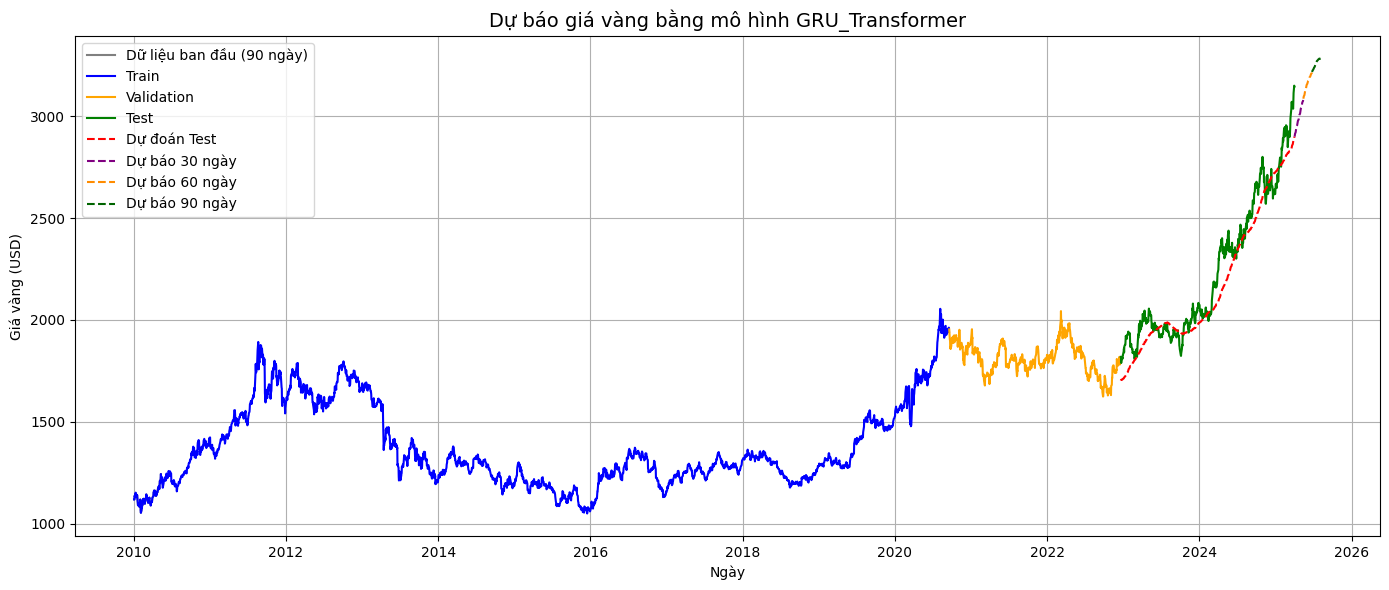

In [37]:
# %% Cell 10: Vẽ dự báo 90 ngày cùng với dữ liệu gốc và dự đoán trên test

import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import numpy as np

train_len = len(train_df)
val_len = len(val_df)
start_idx = train_len + val_len

# Lấy ngày test từ df_all
test_dates = df_all['Date'].iloc[start_idx:start_idx + len(y_trues)].reset_index(drop=True)

# Chuẩn hóa ngược y_true và y_pred về giá trị gốc
y_trues_rescaled = y_trues * scaler.scale_[0] + scaler.mean_[0]
y_preds_rescaled = y_preds * scaler.scale_[0] + scaler.mean_[0]

plt.figure(figsize=(14, 6))

# Vẽ dữ liệu thực tế từng tập
plt.plot(df_all['Date'][:90], 
         df_all["Price"].values[:90]*scaler.scale_[0] + scaler.mean_[0], 
         color='gray', label='Dữ liệu ban đầu (90 ngày)')
plt.plot(df_all['Date'][:train_len], 
         df_all["Price"].values[:train_len]*scaler.scale_[0] + scaler.mean_[0], 
         color='blue', label='Train')
plt.plot(df_all['Date'][train_len:train_len+val_len], 
         df_all["Price"].values[train_len:train_len+val_len]*scaler.scale_[0] + scaler.mean_[0], 
         color='orange', label='Validation')
plt.plot(df_all['Date'][start_idx:], 
         df_all["Price"].values[start_idx:]*scaler.scale_[0] + scaler.mean_[0], 
         color='green', label='Test')

# Vẽ dự đoán trên test
plt.plot(test_dates, y_preds_rescaled, color='red', linestyle='--', label='Dự đoán Test')

# Vẽ dự báo tương lai 30/60/90 ngày (nếu có biến forecast)
try:
    last_test_date = pd.to_datetime(test_dates.iloc[-1])
    full_forecast = np.concatenate([y_preds_rescaled[-1:], forecast])  # forecast là mảng dự báo tương lai
    full_dates = pd.date_range(last_test_date, periods=len(full_forecast), freq=BDay())

    plt.plot(full_dates[1:31], full_forecast[1:31], color='purple', linestyle='--', label='Dự báo 30 ngày')
    plt.plot(full_dates[31:61], full_forecast[31:61], color='darkorange', linestyle='--', label='Dự báo 60 ngày')
    plt.plot(full_dates[61:], full_forecast[61:], color='darkgreen', linestyle='--', label='Dự báo 90 ngày')
except NameError:
    pass  # Nếu forecast chưa được định nghĩa thì bỏ qua

plt.title("Dự báo giá vàng bằng mô hình GRU_Transformer", fontsize=14)
plt.xlabel("Ngày")
plt.ylabel("Giá vàng (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
